Dominant Frequencies and Amplitudes:
Frequency: 49.57 Hz, Amplitude: 6.13
Frequency: 148.71 Hz, Amplitude: 1.77
Frequency: 99.14 Hz, Amplitude: 1.07
Frequency: 247.84 Hz, Amplitude: 1.00


Text(0, 0.5, 'Amplitude')

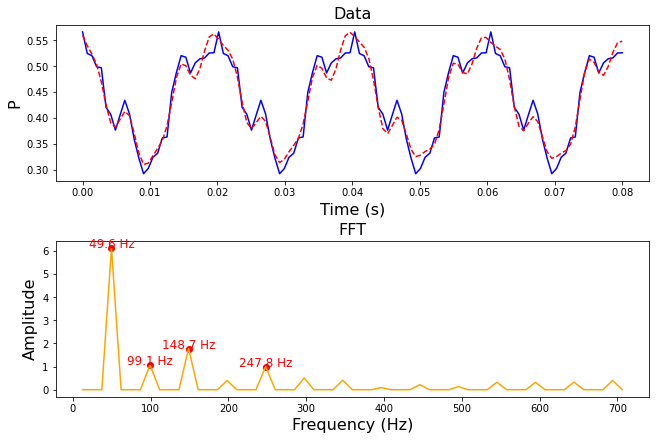

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

# import data
data = np.array([
    0.5662, 0.5245, 0.5202, 0.4989, 0.4969, 0.4206, 0.4072, 0.3765, 0.4057, 
    0.4342, 0.4078, 0.3591, 0.3224, 0.2924, 0.3025, 0.3242, 0.3320, 0.3615, 
    0.3633, 0.4495, 0.4877, 0.5203, 0.5173, 0.4868, 0.5062, 0.5143, 0.5159, 
    0.5255, 0.5259
])
# Extend the data for num_repeats oscillations
n_periods = 4
total_time = 0.02 * n_periods 
time = np.linspace(0, total_time, len(data)*n_periods) # s
data = np.tile(data, n_periods)




# Perform FFT to find dominant frequencies
fft_result = fft(data)
amplitudes = np.abs(fft_result)  # Magnitude of FFT
frequencies = fftfreq(len(time), d=(time[1] - time[0]))  # Frequency axis

# Only consider positive frequencies, excluding 0 Hz
positive_freqs = frequencies[1:len(frequencies)//2]
positive_amplitudes = amplitudes[1:len(frequencies)//2]

# Find the top 4 dominant frequencies
sorted_indices = np.argsort(positive_amplitudes)[::-1]  # Sort by amplitude, descending
dominant_frequencies = positive_freqs[sorted_indices[:4]]  # Take the top 4 frequencies
dominant_amplitudes = positive_amplitudes[sorted_indices[:4]]

# Print dominant frequencies and their amplitudes
print("Dominant Frequencies and Amplitudes:")
for f, a in zip(dominant_frequencies, dominant_amplitudes):
    print(f"Frequency: {f:.2f} Hz, Amplitude: {a:.2f}")

    
    
    
# Fit the data with the inferred function (including offset)
def mixed_sine_wave_with_offset(t, A1, f1, phase1, A2, f2, phase2, A3, f3, phase3, A4, f4, phase4, C):
    return (A1 * np.sin(2 * np.pi * f1 * t + phase1) +
            A2 * np.sin(2 * np.pi * f2 * t + phase2) +
            A3 * np.sin(2 * np.pi * f3 * t + phase3) +
            A4 * np.sin(2 * np.pi * f4 * t + phase4) + C)

initial_guess = [dominant_amplitudes[0], dominant_frequencies[0], 0, 
                 dominant_amplitudes[1], dominant_frequencies[1], 0,
                 dominant_amplitudes[2], dominant_frequencies[2], 0,
                 dominant_amplitudes[3], dominant_frequencies[3], 0,
                 np.mean(data)]
params, _ = curve_fit(mixed_sine_wave_with_offset, time, data, p0=initial_guess)

fitted_signal = mixed_sine_wave_with_offset(time, *params) # fitted signal



# Plot FFT results
fs = 16
fig, ax = plt.subplots(2,1,constrained_layout=True, figsize=(9,6))
ax[0].plot(time, data, label="Extended Data", color="blue")
ax[0].plot(time, fitted_signal, label="Fitted Signal", linestyle="--", color="red")
ax[0].set_title("Data",fontsize=fs)
ax[0].set_xlabel("Time (s)",fontsize=fs)
ax[0].set_ylabel("P",fontsize=fs)

ax[1].plot(positive_freqs, positive_amplitudes, label="FFT Amplitude", color="orange")
ax[1].scatter(dominant_frequencies, dominant_amplitudes, color="red", label="Dominant Frequencies")
for f, a in zip(dominant_frequencies, dominant_amplitudes):
    ax[1].text(f, a, f"{f:.1f} Hz", fontsize=12, color="red", ha="center")
ax[1].set_title("FFT",fontsize=fs)
ax[1].set_xlabel("Frequency (Hz)",fontsize=fs)
ax[1].set_ylabel("Amplitude",fontsize=fs)


In [49]:
n_periods = 4 
n_points = len(fitted_signal)
sample_freq = 1/(0.020/(n_points/n_periods))
trig_type = 3
trig_internal = 1

# rescaling amplitude in volt
fitted_signal = (fitted_signal-0.44)/(np.pi*113e-6); #Hz
fitted_signal = fitted_signal/700000;         #G
#calibration = 0.131 G/A
#to correct 1kHz I need to sent 10 mA in the compensation coil 
fitted_signal = fitted_signal/0.131;         #A
fitted_signal = fitted_signal * 36;          #V  


out = np.append([n_points,sample_freq ,trig_type,trig_internal],fitted_signal,axis=0)

# Open a text file in write mode
with open("output.txt", "w") as file:
    # Write each value in the array to a new line
    for value in out:
        file.write(str(value) + '\n')